In [1]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from os import listdir
from os.path import isfile, join


In [161]:
dataset = pd.read_csv("/content/drive/MyDrive/ML/ML_Data G1/data_new1.csv")

label = {j:i for i,j in enumerate(set(dataset['label']))}
for i,j in label.items():
  dataset['label'] = dataset['label'].replace(i, j)



In [162]:
column_selected = 'std_rmse mean_rmse std_spectral_centroid mean_spectral_centroid std_spectral_bandwidth mean_spectral_bandwidth std_flatness mean_flatness std_rolloff mean_rolloff std_poly_features mean_poly_features std_zero_crossing_rate mean_zero_crossing_rate'

for i in range(1, 13):
    column_selected += f' chroma_stft_mean{i}'
    column_selected += f' chroma_stft_std{i}' 

for i in range(1, 13):
    column_selected += f' chroma_cqt_mean{i}'
    column_selected += f' chroma_cqt_std{i}' 



for i in range(1, 13):
    column_selected += f' chroma_cens_mean{i}'
    column_selected += f' chroma_cens_std{i}' 


for i in range(1, 21):
    column_selected += f' mfcc_mean{i}'
    column_selected += f' mfcc_std{i}' 

for i in range(1,1026):
    column_selected += f' stft_mean{i}'
    column_selected += f' stft_std{i}' 

for i in range(1,129):
  column_selected += f' melspectrogram_mean{i}'
  column_selected += f' melspectrogram_std{i}'

for i in range(1,8):
  column_selected += f' Contrast_mean{i}'
  column_selected += f' Contrast_std{i}'

for i in range(1,7):
  column_selected += f' tonnetz_mean{i}'
  column_selected += f' tonnetz_std{i}'



column_selected = column_selected.split()

In [163]:


dataset_selected = dataset[column_selected]
normalized_df=(dataset_selected-dataset_selected.mean())/dataset_selected.std()
normalized_df

,std_rmse,mean_rmse,std_spectral_centroid,mean_spectral_centroid,std_spectral_bandwidth,mean_spectral_bandwidth,std_flatness,mean_flatness,std_rolloff,mean_rolloff,std_poly_features,mean_poly_features,std_zero_crossing_rate,mean_zero_crossing_rate,chroma_stft_mean1,chroma_stft_std1,chroma_stft_mean2,chroma_stft_std2,chroma_stft_mean3,chroma_stft_std3,chroma_stft_mean4,chroma_stft_std4,chroma_stft_mean5,chroma_stft_std5,chroma_stft_mean6,chroma_stft_std6,chroma_stft_mean7,chroma_stft_std7,chroma_stft_mean8,chroma_stft_std8,chroma_stft_mean9,chroma_stft_std9,chroma_stft_mean10,chroma_stft_std10,chroma_stft_mean11,chroma_stft_std11,chroma_stft_mean12,chroma_stft_std12,chroma_cqt_mean1,chroma_cqt_std1,...,melspectrogram_mean122,melspectrogram_std122,melspectrogram_mean123,melspectrogram_std123,melspectrogram_mean124,melspectrogram_std124,melspectrogram_mean125,melspectrogram_std125,melspectrogram_mean126,melspectrogram_std126,melspectrogram_mean127,melspectrogram_std127,melspectrogram_mean128,melspectrogram_std128,Contrast_mean1,Contrast_std1,Contrast_mean2,Contrast_std2,Contrast_mean3,Contrast_std3,Contrast_mean4,Contrast_std4,Contrast_mean5,Contrast_std5,Contrast_mean6,Contrast_std6,Contrast_mean7,Contrast_std7,tonnetz_mean1,tonnetz_std1,tonnetz_mean2,tonnetz_std2,tonnetz_mean3,tonnetz_std3,tonnetz_mean4,tonnetz_std4,tonnetz_mean5,tonnetz_std5,tonnetz_mean6,tonnetz_std6
0,-1.776361,-1.890013,0.575779,0.473764,-0.951911,0.236299,-0.926362,-0.502375,0.246935,0.201146,-1.600187,-1.649794,1.426688,0.781007,-0.066385,-0.123925,-0.576817,-0.195824,-1.202716,-1.210185,-0.961367,-0.743725,-0.184196,0.334777,0.184290,0.541371,0.463641,0.707657,0.712562,0.849688,0.755373,1.044328,0.685761,1.008383,1.085952,1.019280,0.655657,0.275411,0.566791,0.681436,...,-0.064812,-0.072387,-0.063374,-0.072976,-0.060098,-0.072851,-0.067207,-0.081272,-0.080074,-0.081409,-0.076634,-0.078807,-0.077148,-0.098212,0.015647,-0.891268,0.168605,1.207357,0.116689,1.356944,-1.485471,-0.616133,-1.608171,-1.969981,-0.049499,-0.172065,-1.117297,-1.206400,-0.132985,-0.481768,-0.189143,-0.134834,0.201653,-0.038107,0.296064,-0.167030,0.222565,-0.461106,-0.111003,-0.379460
1,1.419607,0.518392,0.348151,1.967278,-0.077152,1.567126,-0.286380,-0.024879,0.089875,1.777965,1.975452,1.522294,0.724942,1.598655,0.685401,0.440647,0.437935,0.201903,-0.036607,-0.286794,0.451627,-0.028123,0.453150,0.357155,0.272948,0.291751,0.542632,0.587714,0.730336,0.167229,0.987846,1.041420,0.231905,-0.018380,-0.060639,-0.139233,0.667132,0.999001,0.851544,-0.307643,...,0.268613,0.300740,0.281645,0.341639,0.859499,0.830991,2.371784,1.981308,1.609820,1.249989,0.921606,1.364976,1.298896,2.542473,-1.371610,-0.994287,-0.407094,-0.308567,-0.473053,0.593811,-0.802931,0.136483,-0.909569,-0.110463,-0.959477,-0.928214,0.557870,0.700141,-0.089335,-1.024422,-0.434380,-0.641034,0.376761,-0.905351,0.245046,-0.928935,-0.297834,-0.933538,0.042152,-1.046419
2,1.751866,0.597804,1.303708,0.729609,0.512364,0.642239,-0.397942,-0.082040,1.076721,0.597329,0.831097,0.464958,1.963737,0.617143,0.856083,0.486436,1.048569,0.657400,1.042652,0.830901,0.579521,0.176319,0.003259,-0.101080,-0.450633,-0.492334,-0.403105,-0.330861,-0.516849,-0.625366,-0.040591,0.102179,0.411508,0.713376,0.756692,0.502664,1.024664,1.253559,0.799853,-0.039120,...,-0.064659,-0.072023,-0.063189,-0.072506,-0.059817,-0.072088,-0.066705,-0.079962,-0.079069,-0.079790,-0.074957,-0.076109,-0.074199,-0.091592,-0.559358,0.655474,-0.547244,-0.358344,-0.172983,-0.426282,-0.662358,-0.260008,-0.856711,-0.542171,-0.464949,0.134881,0.019308,1.280031,0.019010,-0.570434,-0.028292,-0.861083,0.085135,-0.747938,-0.252826,-0.428130,-0.335304,-0.525706,0.163852,-0.771010
3,0.407008,0.613274,-0.990474,-0.859298,-1.023826,-1.230764,-0.956228,-0.544697,-1.316257,-0.869177,0.049469,0.368196,-0.575233,-0.242730,-1.652691,-1.870389,0.345639,0.777354,1.671590,1.639030,-0.251874,-0.615345,-0.661512,0.911119,-1.060071,-0.740420,-1.294080,-1.074318,-2.024568,-2.540688,-1.198781,-0.8193

In [241]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.02, penalty="l1", dual=False).fit(normalized_df,dataset['label'])
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(normalized_df)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


In [243]:
X_train, X_test, y_train, y_test = train_test_split(X_new, dataset['label'], test_size=int(1379*0.1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=int(1379*0.1), random_state=42)

X_train.shape


(1102, 366)

Feature Selection : 

In [236]:

x_train = torch.FloatTensor(X_train)
y_train = torch.tensor(list(y_train))



x_valid = torch.FloatTensor(X_valid)
y_valid = torch.tensor(list(y_valid))

x_test = torch.FloatTensor(X_test)
y_test = torch.tensor(list(y_test))


In [237]:



class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size1,hidden_size2,dropout = 0.30):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size1  = hidden_size1
            self.hidden_size2  = hidden_size2
            
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size1)
            self.relu1 = torch.nn.ReLU()
            
            self.droput1 = nn.Dropout(dropout)
            self.fc2 = torch.nn.Linear(self.hidden_size1, self.hidden_size2)
            self.relu2 = torch.nn.ReLU()
            
            
            self.fc3 = torch.nn.Linear(self.hidden_size2, 5)
            # self.softmax = torch.nn.LogSoftmax(dim=1)
            self.softmax = torch.nn.LogSoftmax(dim=1)

        def forward(self, x):
            hidden1 = self.fc1(x)
            relu1 = self.relu1(hidden1)
            relu1 = self.droput1(relu1)
            hidden2 = self.fc2(relu1)
            relu2 = self.relu2(hidden2)
            relu2 = self.droput1(relu2)
            output = self.fc3(relu2)
            output = self.softmax(output)
            return output

In [238]:
model = Feedforward(x_train.shape[1], 100,20,dropout = 0.5)

criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)


In [239]:
val_acc = []
train_acc = []
val_loss = []
train_loss =[]

model.train()
epoch = 500

for epoch in range(epoch):
    optimizer.zero_grad()
    # Forward pass
    y_pred = model(x_train)
    # Compute Loss
    
    loss = criterion(y_pred, torch.tensor(y_train, dtype=torch.long))
    acc_Train = accuracy(y_pred.argmax(1),y_train)
    _val_loss , _val_acc = validation(x_valid,y_valid)
    val_acc.append(_val_acc)
    train_acc.append(acc_Train)
    val_loss.append(_val_loss)
    train_loss.append(loss)

    loss.backward()
    optimizer.step()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app


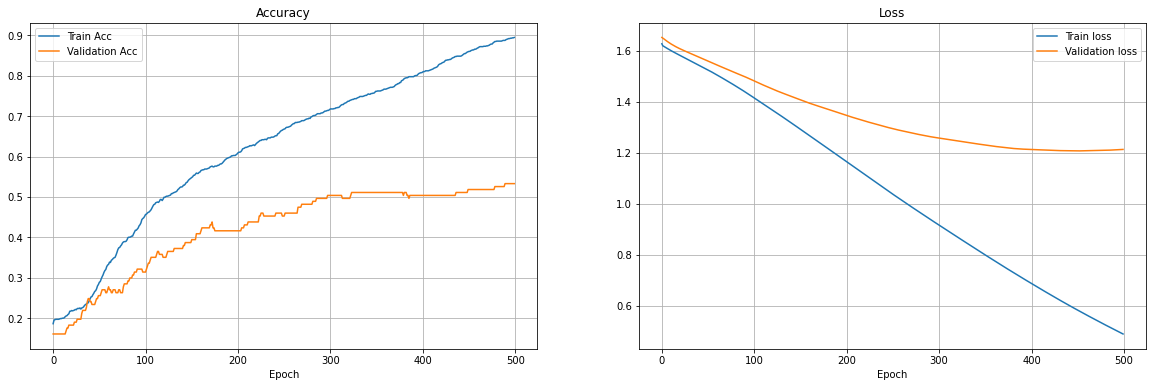

In [223]:

fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.xlabel("Epoch")
plt.grid()

plt.show()

Accuracy:  0.583941605839416 F1 score(macor): 0.5854768939244902


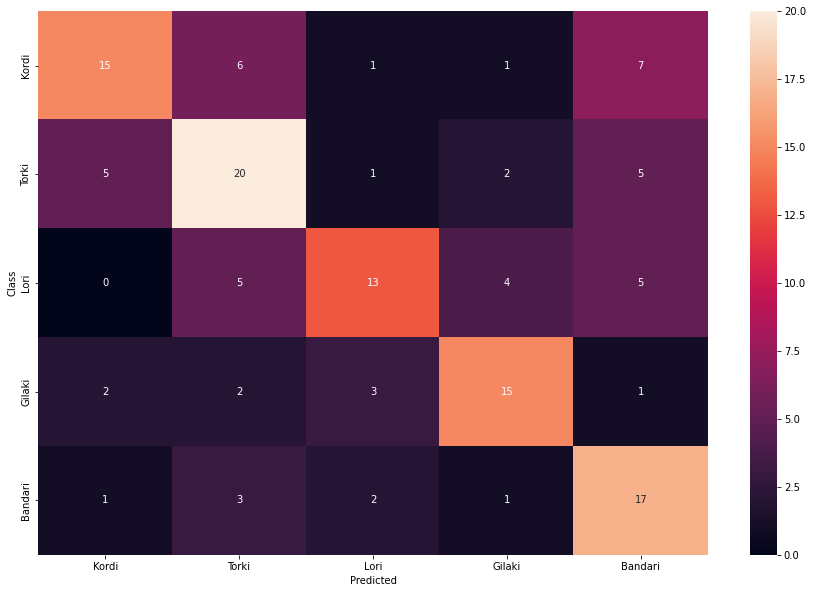

In [224]:
from sklearn.metrics import confusion_matrix
import seaborn as sns # for data visualization
from sklearn.metrics import f1_score




def test_(x_test,y_test):
  model.eval()
  fig, ax = plt.subplots(figsize=(15, 10))
  y_pred = model(x_test)
  # before_train = criterion(y_pred, y_test)
  val_acc = accuracy(y_test,y_pred.argmax(1))
  f1 = f1_score(y_test,y_pred.argmax(1), average='macro')
  confmatrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred.argmax(1)), columns = list(label.keys()))

  confmatrix_df['Class'] = list(label.keys())
  confmatrix_df = confmatrix_df.set_index(['Class'])
  sns.heatmap(confmatrix_df,annot=True)
  plt.xlabel("Predicted")
  return val_acc,f1

acc,f1  = test_(x_test,y_test) 
print("Accuracy: ",acc ,"F1 score(macor):",f1)

